<a href="https://colab.research.google.com/github/NasreddineG/Machine-Learning/blob/main/CNN_Detection_Emotion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Détection d'émotions sur des images grâce au CNN***



L'objectif du projet est de construire à l'aide d'un CNN (Convolution Neural Network ou réseau neuronal convolutif) une reconnaissance des émotions sur des images.

Pour ce faire, il nous faut une base d'apprentissage et d'entraînement. Pour cela, nous allons utiliser pour ça le dataset FER-2013 disponible sur Kaggle (https://www.kaggle.com/msambare/fer2013).

Ce dataset est constitué d'images de visages en niveaux de gris de 48x48 pixels. Les images sont plus ou moins centrés et occupent à peu près le même espace.

Il existe 7 émotions différentes dans ces dataset et chaque visages appartient à l'une des 7 émotions suivantes :

- La colère

- Le dégoût

- La peur

- La joie

- La tristesse

- La surprise

- Neutre

.

.

. **/!\ Le GPU doit être sélectionné comme accélérateur matériel pour la bonne exécution.**

Pour importer le dataset zippé sur collab, il faut l'importer dans un premier temps sur votre drive et connecter votre colab à votre drive.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Une fois cette connexion réalisée, on va dézipper le fichier se trouvant sur le drive. 


Cette commande est à exécuter uniquement lors de la première importation du fichier, par la suite le dataset dézippé est définitivement stocké sur votre Drive.

In [ ]:
!unzip /content/drive/MyDrive/Data/archive.zip -d /content/drive/MyDrive/Data/dataset

On réalise les importations nécessaires

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cv2 as cv
import os
import tensorflow as tf
import keras
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')

# ***Extraction des données***

In [4]:
#Les noms des classes pour connaitre les 7 émotions
Class_name_train=os.listdir("/content/drive/MyDrive/Data/dataset/train")
print('Training Set =', Class_name_train)
Class_name_test=os.listdir("/content/drive/MyDrive/Data/dataset/test")
print('Test Set =', Class_name_test)

Training Set = ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
Test Set = ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


                         ********************************fearful*************************


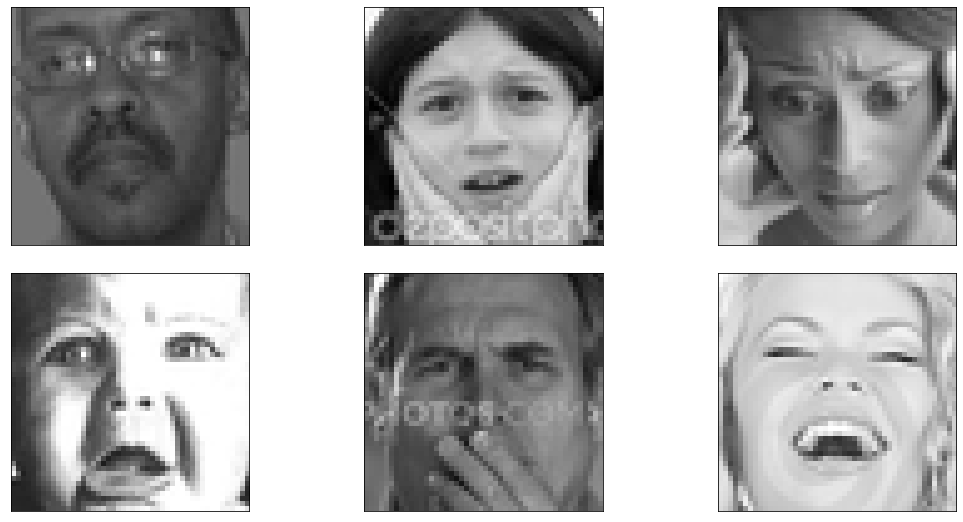

In [5]:
#  Plot 12 images aléatoires pour vérifier l'ensemble des données
plt.figure(figsize=(15,11))
n= np.random.randint(0,7)
path = f"/content/drive/MyDrive/Data/dataset/train/{Class_name_train[n]}"
print(f"                         ********************************{Class_name_train[n]}*************************")
for i in range(1,7):
    plt.subplot(3,3,i)
    plt.tight_layout()
    rand_img = cv.imread(path +'/'+ np.random.choice(sorted(os.listdir(path))))
    plt.imshow(rand_img)
    plt.xticks([])
    plt.yticks([])

# ***CLASSIFICATION DES DONNÉES :***

Analysons les jeux de données que nous avons pour voir les proportions des différentes classes et la répartition entre le dataset train et test.

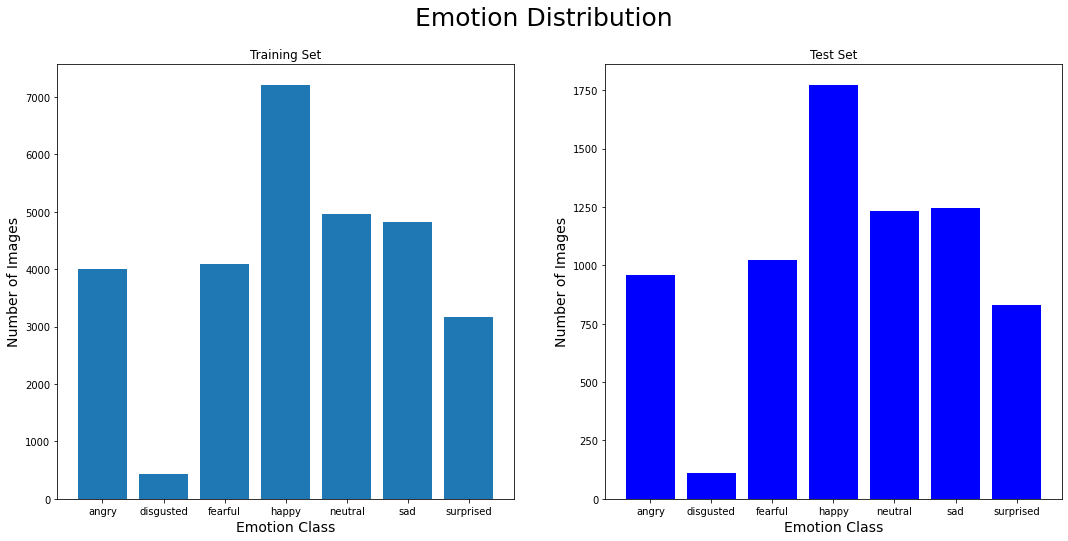

In [6]:
plt.figure(figsize=(18,8))
plt.suptitle('Emotion Distribution', fontsize=25)

ax1 = plt.subplot(1,2,1)
ax1.set_title('Training Set')
plt.xlabel('Emotion Class', fontsize=14)
plt.ylabel('Number of Images', fontsize=14)
train_count=[]
for i in Class_name_test:
    train_count.append(len(os.listdir("/content/drive/MyDrive/Data/dataset/train/"+i+"/")))
plt.bar(Class_name_train,train_count)

ax2 = plt.subplot(1, 2, 2)
ax2.set_title('Test Set')
plt.xlabel('Emotion Class', fontsize=14)
plt.ylabel('Number of Images', fontsize=14)
train_count=[]
for i in Class_name_test:
    train_count.append(len(os.listdir("/content/drive/MyDrive/Data/dataset/test/"+i+"/")))
plt.bar(Class_name_test,train_count,color="blue")
plt.show()

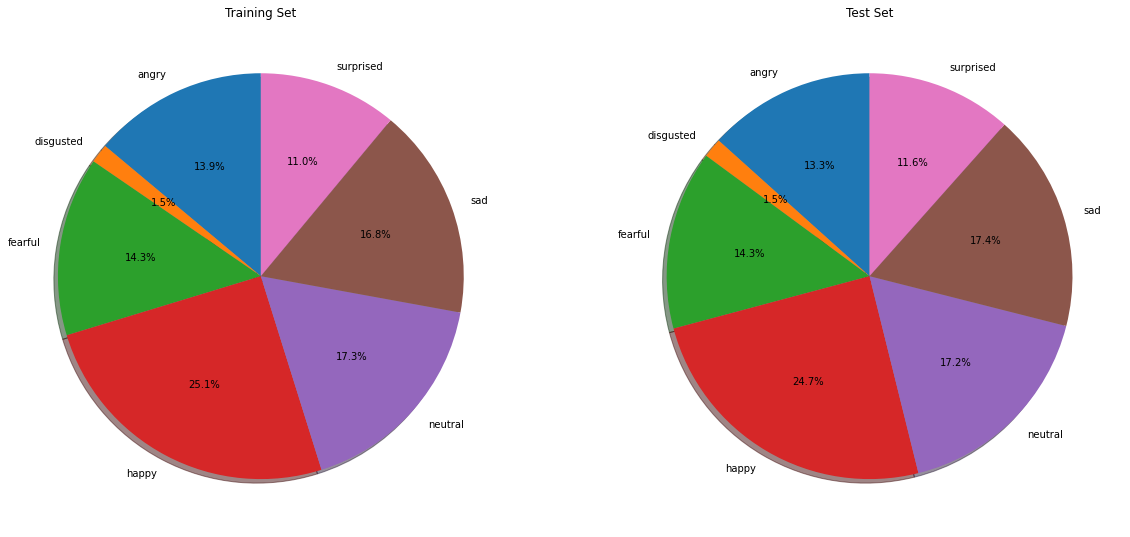


Emotion : angry
	Training : 3995
	 Testing : 958

Emotion : disgusted
	Training : 436
	 Testing : 111

Emotion : fearful
	Training : 4097
	 Testing : 1024

Emotion : happy
	Training : 7215
	 Testing : 1774

Emotion : neutral
	Training : 4965
	 Testing : 1233

Emotion : sad
	Training : 4830
	 Testing : 1247

Emotion : surprised
	Training : 3171
	 Testing : 831


In [7]:
train_path = "/content/drive/MyDrive/Data/dataset/train"
test_path = "/content/drive/MyDrive/Data/dataset/test"

x_train = np.array([ len(os.listdir(train_path+'/'+i+'/')) for i in Class_name_train ])
x_test = np.array([ len(os.listdir(test_path+'/'+i+'/')) for i in Class_name_test ])
label = Class_name_train
  
fig, axes = plt.subplots(1, 2, figsize=(20,10))
axes[0].pie(x_train, labels=label, autopct='%1.1f%%',shadow=True, startangle=90)
axes[1].pie(x_test, labels=label, autopct='%1.1f%%',shadow=True, startangle=90)
axes[0].set_title('Training Set')
axes[1].set_title('Test Set')
plt.show()

for i in Class_name_train:
    print('\nEmotion : ' + i )
    print('\tTraining : ' + str(len(os.listdir(train_path+'/'+i+'/'))) +'\n\t Testing : ' + str(len(os.listdir(test_path+'/'+i+'/'))))

On remarque que les pourcentages pour chaque émotion sont un peu près similaire entre le test et le train.

Ainsi, les données sont cohérentes et peuvent être analysées. 

Maintenant que nous avons une meilleure compréhension de nos données d'image, nous pouvons effectuer un prétraitement des données sur nos images pour nous aider à étendre notre ensemble de données et à le rendre plus équilibré.

Le générateur d'images Keras ImageDataGenerator nous permet ainsi d'effectuer une augmentation d'image très facilement.

In [8]:
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

print("Train:")
train_generator = train_datagen.flow_from_directory(directory = "/content/drive/MyDrive/Data/dataset/train",
                                                    target_size = (48,48),
                                                    batch_size = 64,
                                                    color_mode = "grayscale",
                                                    class_mode = "categorical")

print("\nTest:")
test_generator = test_datagen.flow_from_directory(directory = "/content/drive/MyDrive/Data/dataset/test",
                                                              target_size = (48,48),
                                                              batch_size = 64,
                                                              color_mode = "grayscale",
                                                              class_mode = "categorical")


Train:
Found 28709 images belonging to 7 classes.

Test:
Found 7178 images belonging to 7 classes.


L'ensemble d'entraînement comprend 28 709 images tandis que l'ensemble de test lui en comprend 7 178.

Ce qui est logique pour permettre de bien entraîner le modèle avant de le tester. Cependant, les proportions pour chaque émotion sont similaires ce qui est le plus important pour avoir un résultat réaliste et optimal.

# ***Convolution Neural Network : CNN***

In [9]:
CNN= Sequential()
CNN.add(Conv2D(32,(3,3),padding='same',activation='relu',input_shape=(48,48,1)))
CNN.add(Conv2D(64,(3,3),padding='same',activation='relu'))
CNN.add(BatchNormalization())
CNN.add(MaxPool2D(pool_size=(2, 2)))
CNN.add(Dropout(0.25))

CNN.add(Conv2D(128,(3,3),padding='same',activation='relu'))
CNN.add(Conv2D(256,(3,3),padding='same',activation='relu'))
CNN.add(BatchNormalization())
CNN.add(MaxPool2D(pool_size=(2, 2)))
CNN.add(Dropout(0.25))

CNN.add(Conv2D(256,(3,3),padding='same',activation='relu'))
CNN.add(BatchNormalization())
CNN.add(MaxPool2D(pool_size=(2, 2)))
CNN.add(Dropout(0.25))
     

CNN.add(Flatten()) 

CNN.add(Dense(100,activation = 'relu'))

CNN.add(Dense(50,activation = 'relu'))

CNN.add(Dense(225,activation = 'relu'))

CNN.add(BatchNormalization())
CNN.add(Dropout(0.25))

CNN.add(Dense(7, activation='softmax'))

CNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       7

Avant de lancer le CNN, vérifiez que vous êtes en GPU. 

Pour être sûr que colab exécute le code en GPU on va lui demander avant l'éxecution du CNN de nous confirmer le tf.device qu'il utilise.

In [10]:
#Vérification que collab utilise le GPU
with tf.device("/device:GPU:0"):
  device_name = tf.test.gpu_device_name()
  print(device_name)
  if device_name == '/device:GPU:0':
    print("ok")
  else : 
    print("NON")

  CNN.compile(loss='categorical_crossentropy',optimizer = tf.keras.optimizers.Adam(lr=0.0005),metrics=['accuracy'])
  history=CNN.fit_generator(train_generator, steps_per_epoch=28709 // 64, epochs=50, validation_data=test_generator, validation_steps=7178 // 64)

/device:GPU:0
ok
Epoch 1/50
448/448 [==============================] - 61s 125ms/step - loss: 1.9124 - accuracy: 0.2686 - val_loss: 1.9045 - val_accuracy: 0.2755
Epoch 2/50
448/448 [==============================] - 57s 127ms/step - loss: 1.5250 - accuracy: 0.4182 - val_loss: 1.4275 - val_accuracy: 0.4487
Epoch 3/50
448/448 [==============================] - 56s 124ms/step - loss: 1.3070 - accuracy: 0.5005 - val_loss: 1.3375 - val_accuracy: 0.4927
Epoch 4/50
448/448 [==============================] - 55s 123ms/step - loss: 1.1913 - accuracy: 0.5508 - val_loss: 1.2270 - val_accuracy: 0.5318
Epoch 5/50
448/448 [==============================] - 55s 124ms/step - loss: 1.1056 - accuracy: 0.5856 - val_loss: 1.1161 - val_accuracy: 0.5730
Epoch 6/50
448/448 [==============================] - 55s 123ms/step - loss: 1.0286 - accuracy: 0.6150 - val_loss: 1.1214 - val_accuracy: 0.5753
Epoch 7/50
448/448 [==============================] - 56s 125ms/step - loss: 0.9496 - accuracy: 0.6451 - val_loss

In [11]:
CNN.evaluate(test_generator)

113/113 [==============================] - 11s 100ms/step - loss: 1.9304 - accuracy: 0.6223


[1.930417776107788, 0.6223182082176208]

On remarque que la précison de notre modèle après avoir exécuté 50 époques est de 62%.

# ***Analyse des résultats :***

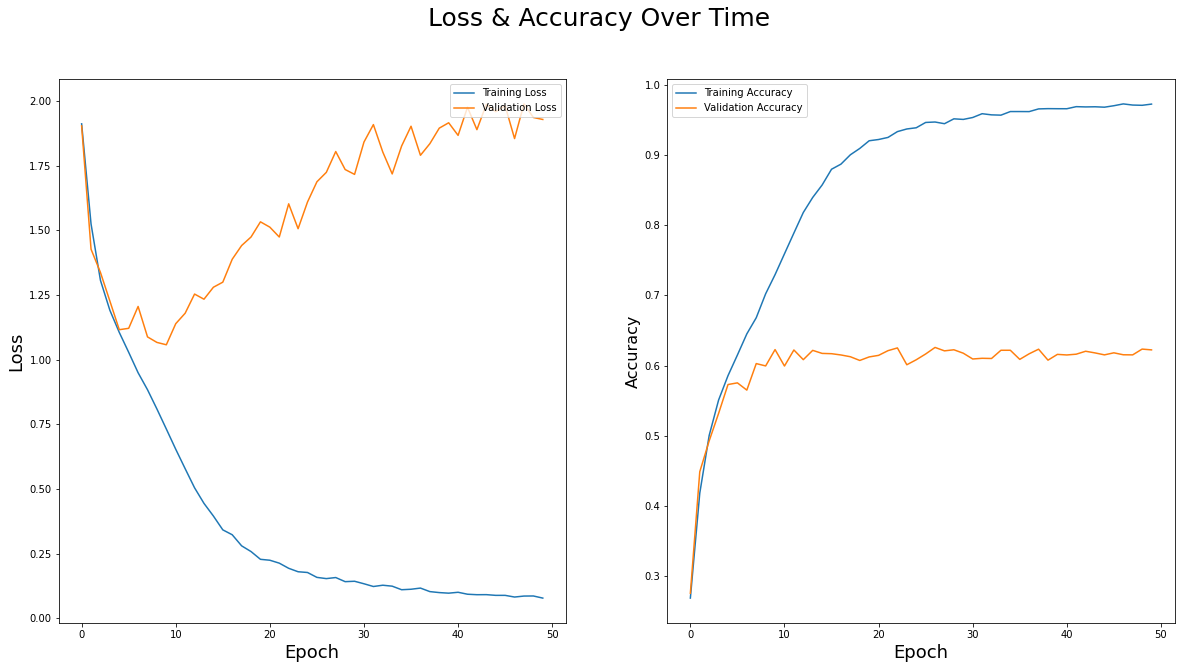

In [12]:
plt.figure(figsize=(20,10))
plt.suptitle('Loss & Accuracy Over Time', fontsize=25)

plt.subplot(1, 2, 1)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.plot(history.history["loss"], label='Training Loss')
plt.plot(history.history["val_loss"], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='upper left')
plt.show()


Concernant la précision, on peut remarquer que la précision du train et du test est à la première itération assez faible (respectivement 27% et 28%).

Cependant, durant les itérations, on remarque une progression. En effet, après 50 itérations, nous sommes à une précision de 97% pour le train  et une précision de 62% pour le dataset test.

Concernant les pertes, on peut remarquer que les pertes  diminuent en passant  de 1.91 à 0.08 pour l'entraînement  et de 1.90 à 1.92 pour le test. 

Cependant, cela est étrange que les pertes lors du test descendent à 1.1 en 10 itérations avant de remonter par la suite pour finir à une perte plus élévée que lors de la première itération.

Au vu des ces résultats, et de la différence majeures entre l'entraînement et le test nous pouvons supposer que notre modèle a fait du surapprentissage.

Pour remédier à ça, on peut ***agrandir l'échantillon d'entraînement et éventuellement augmenter le nombre d'étapes***.


# ***Analyse des émotions :***

113/113 [==============================] - 13s 117ms/step


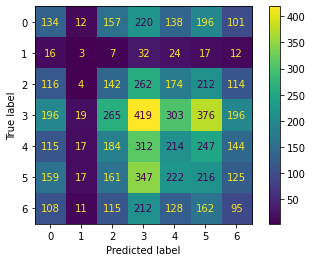


 
 {'angry': 0, 'disgusted': 1, 'fearful': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprised': 6}


In [13]:
#Matrice de confusion

y_pred = CNN.predict(test_generator)

y_pred_labels = []
for i in y_pred:
    y_pred_labels.append(np.argmax(i))

y_actual = test_generator.classes[test_generator.index_array]

cm = metrics.confusion_matrix(y_actual, y_pred_labels)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

print("\n","\n",test_generator.class_indices)

Le modèle ne reconnaît pas sans grande surprise les images de dégoût au vu du pourcentage très faiblement présent dans les datasets. Cependant, le modèle classe en grande majorité les images "dégoûtées" dans les catégorie énervée, triste et neutre ce qui reste cohérent.

L'émotion la mieux reconnu est la joie avec 419 bonnes images, ce qui est cohérent sachant que c'est le plus gros pourcentage dans la répartition des images dans chaque classe. Cependant, les 220 images joyeuses classées comme énervées sont surprenantes.

On remarque que les performances ne sont pas aussi bonnes pour les autres classes. L'une des raisons de ce phénomène pourrait être le fait que ces classes contiennent moins de données que les classes heureuses.

En effet, il y a une certaines corrélation entre les classes contenant le plus d'image et celle ayant les meilleurs résultats qui sont les émotions joyeux, neutre.

In [14]:
#Sauvegarder le modèle
keras_file="CNN"
tf.keras.models.save_model(CNN,keras_file)